<a href="https://colab.research.google.com/github/cogma/llm-book/blob/main/chapter05/5-3-sentiment-analysis-analysis-wrime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第5章 大規模言語モデルのファインチューニング

**注意**
2023/7/28現在、MARC-jaのデータセットの配布元のリンクが切れており、書籍上の5.2、5.3、5.5.4節に掲載されているコードにおいて、データセット読み込みの箇所でエラーが出る状態です。こちらのノートブックは、MARC-jaと同様の感情分析のデータセットであるWRIMEを用いて書籍と同様のコードを実行するために用意されています。

## 5.3 感情分析モデルのエラー分析

In [1]:
!pip install 'datasets<4.0.0' 'transformers[ja,torch]<4.41.0'  matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.8 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha25

### 5.3.1 モデルの予測結果の取得

In [2]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cuda:0")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

README.md: 0.00B [00:00, ?B/s]

wrime-sentiment.py: 0.00B [00:00, ?B/s]

default/train/0000.parquet:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

default/validation/0000.parquet:   0%|          | 0.00/178k [00:00<?, ?B/s]

default/test/0000.parquet:   0%|          | 0.00/178k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20149 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1608 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1781 [00:00<?, ? examples/s]

In [4]:
from tqdm import tqdm

# ラベル名の情報を取得するためのClassLabelインスタンス
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["label"])

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

9it [00:10,  1.33it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
1608it [00:30, 51.91it/s]


### 5.3.2 全体的な傾向の分析

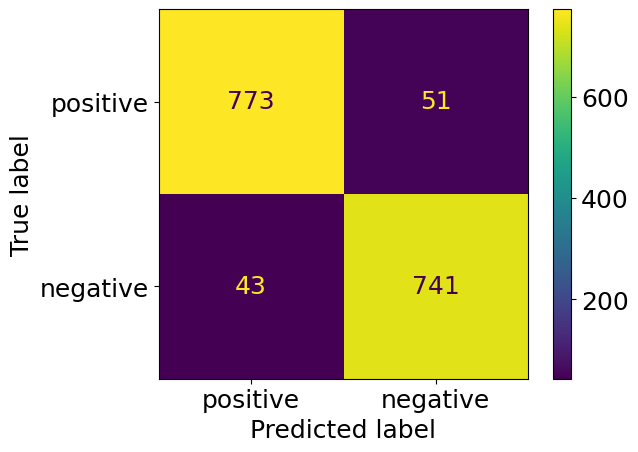

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

# 混同行列の作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)
# 混同行列を画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=class_label.names
).plot()

### 5.3.3 モデルのショートカットに注意

In [6]:
# 予測が誤った事例を収集
failed_results = [
    res for res in results if res["pred_label"] != res["true_label"]
]
# モデルの予測確率が高い順にソート
sorted_failed_results = sorted(
    failed_results, key=lambda x: -x["pred_prob"]
)
# 高い確率で予測しながら誤った事例の上位2件を表示
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"レビュー文：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率: {top_result['pred_prob']:.4f}")
    print("----------------")

レビュー文：何のこれしき会社員だった頃の辛さに比べれば。まあ種類が違うけど。


予測：negative
正解：positive
予測確率: 0.9993
----------------
レビュー文：今年のプリキュアの決め台詞が、
 
「お大事に」

今年にマッチングし過ぎてて、プリキュアスタッフの先見の明がすご過ぎるし、何が言いたいかと言うと変身する棒を買わされました。
予測：positive
正解：negative
予測確率: 0.9993
----------------
レビュー文：ツイッター早朝部、いくわよ！！ あと諸事情により数人ブロックさせて頂きました…申し訳ない……
予測：negative
正解：positive
予測確率: 0.9992
----------------
レビュー文：酒はぬるめの 燗がいい 肴は炙った イカでいい←もっといいもの食えよ
予測：positive
正解：negative
予測確率: 0.9992
----------------
レビュー文：できれば今すぐお線香あげにいきたい
予測：positive
正解：negative
予測確率: 0.9992
----------------
